In [1]:
import numpy as np
#import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import PIL.ImageDraw
import PIL.Image
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Set basic parameters

In [43]:
overwrite = False
N = 50 # pupil array quadrant width after binning
iD = 20
oD = 80
#aligntol = 4 # units of thousandths of pupil diameter
L = 1000 # starting array width
D = 1000 # starting pupil diameter
symm = 'quart' # set to either 'quart' or 'half'
shape = 'ann' # set to 'ann' or 'hex'
edge = 'gray' # set to 'gray' or 'round'

In [32]:
#LS_dir = os.path.abspath("../InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS")
LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v4/LS")
if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_v4/LS already exists


## Define annular stop

In [33]:
inD = float(iD)/100
outD = float(oD)/100
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
Lyot_stop = np.ones((L,L))
Lyot_stop[inside_ann] = 0.
Lyot_stop[outside_ann] = 0.

In [34]:
inD = float(iD)/100
outD = float(oD)/100
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)

if shape is 'hex':
    xycent = (L/2-0.5,L/2-0.5)
    hexagon_obj = matplotlib.patches.RegularPolygon(xycent,6,radius=outD*D/2/np.cos(np.pi/6))
    hexagon_verts = hexagon_obj.get_verts()
    hexagon_img = PIL.Image.new('L', (L,L), 0)
    PIL.ImageDraw.Draw(hexagon_img).polygon(list(hexagon_verts.ravel()), outline=1, fill=1)
    hexagon_mask = np.array(hexagon_img)
    Lyot_stop = hexagon_mask
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    Lyot_stop[inside_ann] = 0.
else:
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
    Lyot_stop = np.ones((L,L))
    Lyot_stop[inside_ann] = 0.
    Lyot_stop[outside_ann] = 0.

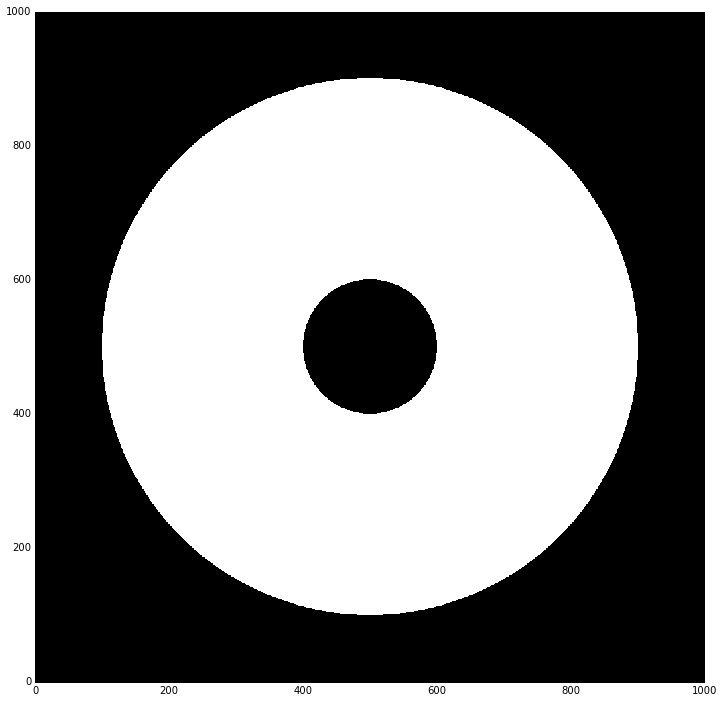

In [35]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [36]:
#scalefac = float(N)/(D/2)
#Lyot_stop_binned = skimage.transform.rescale(Lyot_stop, scalefac, order=1)

In [37]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original LS array {0:d}x".format(scalefac))
Lyot_stop_binned = np.reshape(Lyot_stop, (Lyot_stop.shape[0]/scalefac, scalefac, 
                                          Lyot_stop.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Binning the original LS array 10x


In [38]:
Lyot_stop.shape

(1000, 1000)

In [39]:
L_bin = Lyot_stop_binned.shape[0]
if symm is 'half':
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_half).astype(int)
    print Lyot_stop_binned_crop.shape
else:
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_crop).astype(int)
    print Lyot_stop_binned_crop.shape

(50, 50)


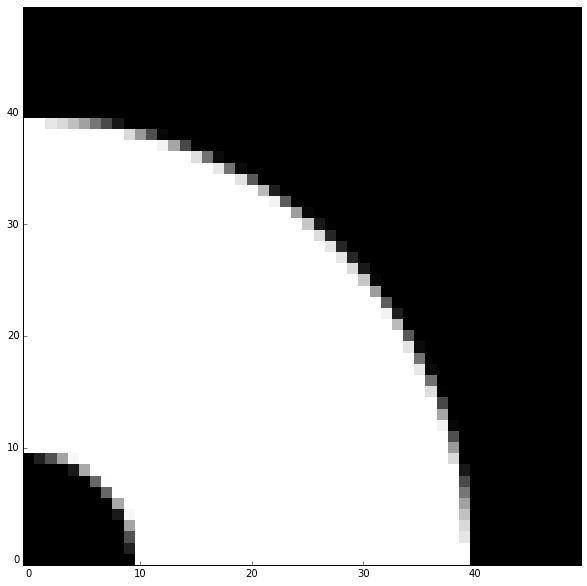

In [40]:
if symm is 'half':
    plt.figure(figsize=(20,10))
    #plt.imshow(Lyot_stop_binned_crop_binary)
    plt.imshow(Lyot_stop_binned_crop)
else:
    plt.figure(figsize=(10,10))
    plt.imshow(Lyot_stop_binned_crop)
    #plt.imshow(Lyot_stop_binned_crop_binary)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [41]:
if symm is 'half':
    LS_dat_fname_tail = "LS_half_{0:s}{1:02d}D{2:02d}_clear_N{3:04d}.dat".format(
                         shape, int(round(100*inD)), int(round(100*outD)), N)
else:
    LS_dat_fname_tail = "LS_quart_{0:s}{1:02d}D{2:02d}_clear_N{3:04d}.dat".format(
                         shape, int(round(100*inD)), int(round(100*outD)), N)

LS_dat_fname = os.path.join(LS_dir, LS_dat_fname_tail)

if not os.path.exists(LS_dat_fname) or overwrite==True:
    if edge is 'gray':
        np.savetxt(LS_dat_fname, Lyot_stop_binned_crop, fmt='%.6f', delimiter=" ")
    else: # store version rounded to binary integers
        np.savetxt(LS_dat_fname, Lyot_stop_binned_crop_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LS array to {0:s}".format(LS_dat_fname))
else:
    print("LS array {0:s} already exists, will not overwrite".format(LS_dat_fname))

Wrote binned, cropped LS array to /astro/opticslab1/SCDA/Apertures/InputMasks_v4/LS/LS_quart_ann20D80_clear_N0050.dat


In [42]:
#if os.path.exists(LS_dat_fname): os.remove(LS_dat_fname)